# Multi-tissue classification colorectal cancer

**Table of Contents**                                                                      
Step1: Environment Setup                                                                          
Step2: Data Loading and Preparation                                                                      
Step3: Analyzing Class Distribution                                                          
Step4: Data Augmentation for Minority Classes                                                            
Step5: Splitting the Dataset                                                                                     
Step6: Preparing Data Generators                                                             
Step7: Building the Model                                                                                       
Step8: Compiling the Model with Class Weights                                                  
Step9: Implementing Learning Rate Scheduling and Early Stopping                                      
Step10: Training the Model                                                             
Step11: Evaluating the Model                                                                   
Step12: Conclusion and Next Steps                                                           



**Step: 1 Environment Setup**

In [1]:
# Data manipulation and analysis
import os
import numpy as np
import pandas as pd
from glob import glob

# Image processing
from PIL import Image

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt

**Step 2: Loading Data**


In [2]:
# Assuming the dataset is in a folder named 'dataset'
data_dir = '/kaggle/input/annotated-tiles-of-colorectal-cancer/No_Norm'

'''# Print the subfolders to verify class names
subfolders = [f.name for f in os.scandir(data_dir) if f.is_dir()]
#print("Subfolders found in data_dir:", subfolders)
classes = subfolders  # Use the subfolder names as class names


# Initialize lists to hold image data and labels
image_data = []
image_labels = []

# Loop through each class directory
for label, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)  # Get the full path to the class directory
    # Get all image file paths in the class directory
    image_files = glob(os.path.join(class_path, '*.png'))  # Adjust the extension if necessary

    print(f"Processing {len(image_files)} images for class '{class_name}'")

    # Loop through and process each image file
    for image_file in image_files:
        try:
            # Open and convert the image to RGB (if necessary)
            img = Image.open(image_file).convert('RGB')
            # Optionally, resize the image (if required)
            img = img.resize((150, 150))  # Ensure the size matches your expected input
            # Convert the image to a NumPy array
            img_array = np.array(img)
            # Append to the data and labels list
            image_data.append(img_array)
            image_labels.append(label)  # Use the numerical label
        except Exception as e:
            print(f"Error processing image {image_file}: {e}")'''

# Get class names from subdirectory names
classes = sorted([d.name for d in os.scandir(data_dir) if d.is_dir()])
print("Classes:", classes)


# Initialize lists to hold file paths and labels
image_paths = []
image_labels = []

# Map class names to numerical labels
class_to_label = {class_name: idx for idx, class_name in enumerate(classes)}
print("Class to label mapping:", class_to_label)

# Loop through each class directory and collect file paths
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    # Get all image file paths in the class directory
    image_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith('.png')]
    # Append file paths and labels
    image_paths.extend(image_files)
    image_labels.extend([class_to_label[class_name]] * len(image_files))
    #print(f"Processing {len(image_files)} images for class '{class_name}'")

print(f"Total images found: {len(image_paths)}")

Classes: ['01_TUM', '02_MUSC_STROMA', '03_LYM', '04_DEBRIS_MUCUS', '05_NORM', '06_ADI']
Class to label mapping: {'01_TUM': 0, '02_MUSC_STROMA': 1, '03_LYM': 2, '04_DEBRIS_MUCUS': 3, '05_NORM': 4, '06_ADI': 5}
Total images found: 5984


**3. Analyzing Class Distribution**

Class counts before augmentation:
 class_name
02_MUSC_STROMA     2875
05_NORM            2388
04_DEBRIS_MUCUS     485
01_TUM              103
03_LYM               72
06_ADI               61
Name: count, dtype: int64


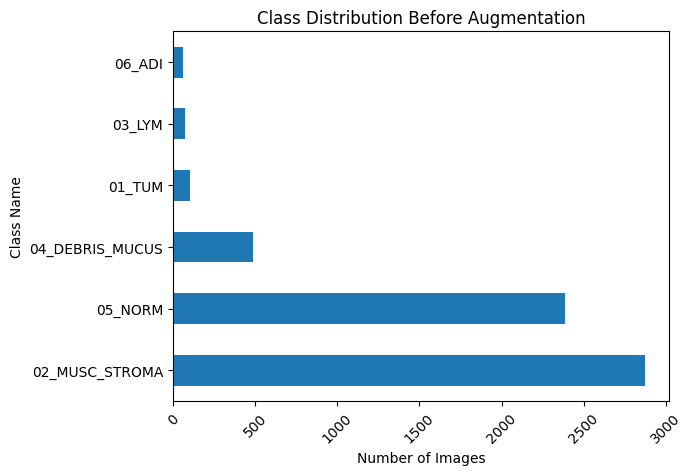

In [17]:
# Create a DataFrame to aid in analysis
df = pd.DataFrame({
    'image_path': image_paths,
    'label': image_labels
})

# Map numerical labels to class names
label_to_class = {v: k for k, v in class_to_label.items()}
df['class_name'] = df['label'].map(label_to_class)

# Display class counts
class_counts = df['class_name'].value_counts()
print("Class counts before augmentation:\n", class_counts)

# Plot class distribution
class_counts.plot(kind='barh')
plt.title('Class Distribution Before Augmentation')
plt.xlabel('Number of Images')
plt.ylabel('Class Name')
plt.xticks(rotation=45)
plt.show() 

**4. Data Augmentation for Minority Classes**


In [8]:
# Define data augmentation transformations
data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Create an instance of ImageDataGenerator with the defined transformations
datagen = ImageDataGenerator(**data_gen_args)



def balanced_data_generator(df, batch_size, target_size, datagen):
    '''
    A generator that yields batches of images and labels, balancing classes by oversampling minority classes.
    '''
    # Get the class counts
    class_counts = df['label'].value_counts()
    max_count = class_counts.max()
    class_indices = {label: df[df['label'] == label].index for label in class_counts.index}

    while True:
        batch_paths = []
        batch_labels = []

        # Oversample minority classes
        for label, indices in class_indices.items():
            num_samples = max_count - len(indices)
            if num_samples > 0:
                extra_indices = np.random.choice(indices, size=num_samples, replace=True)
                indices = indices.union(extra_indices)

            # Shuffle indices
            indices = np.random.permutation(indices)
            batch_paths.extend(df.loc[indices, 'image_path'].tolist())
            batch_labels.extend(df.loc[indices, 'label'].tolist())

        # Combine and shuffle
        combined = list(zip(batch_paths, batch_labels))
        np.random.shuffle(combined)
        batch_paths, batch_labels = zip(*combined)

        # Yield batches
        for i in range(0, len(batch_paths), batch_size):
            batch_end = min(i + batch_size, len(batch_paths))
            batch_images = []
            batch_labels_one_hot = []

            for j in range(i, batch_end):
                # Load and preprocess the image
                img = Image.open(batch_paths[j]).convert('RGB')
                img = img.resize(target_size)
                img_array = np.array(img)
                batch_images.append(img_array)
                batch_labels_one_hot.append(to_categorical(batch_labels[j], num_classes=len(classes)))

            # Convert lists to arrays
            X_batch = np.array(batch_images)
            y_batch = np.array(batch_labels_one_hot)

            # Apply real-time data augmentation
            augmented_iterator = datagen.flow(X_batch, y_batch, batch_size=batch_size, shuffle=False)
            X_batch_augmented, y_batch_augmented = next(augmented_iterator)

            # Normalize
            X_batch_augmented = X_batch_augmented / 255.0

            yield X_batch_augmented, y_batch_augmented

**Step 5: Split the Dataset**


In [9]:
# Split into training and temp (validation + test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Split temp into validation and test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 4787
Validation set size: 598
Test set size: 599


**6. Preparing Data Generators**


6.1. Training Data Generator


In [10]:
# Parameters
batch_size = 32
target_size = (150, 150)  # Adjust as needed

# Training data generator
train_generator = balanced_data_generator(
    train_df,
    batch_size=batch_size,
    target_size=target_size,
    datagen=datagen
)

# Calculate steps per epoch
steps_per_epoch = len(train_df) * 2 // batch_size  # Oversampling will effectively double the data

6.2. Validation Data Generator

In [11]:
# Validation data preparation
def prepare_dataset(df):
    images = []
    labels = []

    for idx, row in df.iterrows():
        img = Image.open(row['image_path']).convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img)
        images.append(img_array)
        labels.append(row['label'])

    X = np.array(images) / 255.0
    y = to_categorical(labels, num_classes=len(classes))
    return X, y

# Prepare validation and test datasets
X_val, y_val = prepare_dataset(val_df)
X_test, y_test = prepare_dataset(test_df)

print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Validation set shape: (598, 150, 150, 3), (598, 6)
Test set shape: (599, 150, 150, 3), (599, 6)


# Step 9: Model Building

In [12]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
  
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       9,470,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,565,894 (36.49 MB)

 Trainable params: 9,565,446 (36.49 MB)

 Non-trainable params: 448 (1.75 KB)

8. Compiling the Model with Class Weights


In [13]:
# Compute class weights based on training data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

# Convert to a dictionary
class_weights = {i: class_weights[i] for i in range(len(classes))}
print("Class weights:", class_weights)

Class weights: {0: 9.729674796747968, 1: 0.3468840579710145, 2: 13.755747126436782, 3: 2.05627147766323, 4: 0.4177137870855148, 5: 16.282312925170068}


In [14]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2, #10
    min_lr=1e-6
)

callbacks = [early_stopping, reduce_lr]

In [18]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=(X_val, y_val),
    #class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 105s 318ms/step - accuracy: 0.5719 - loss: 5.6436 - val_accuracy: 0.0786 - val_loss: 14.2722 - learning_rate: 0.0010
Epoch 2/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 80s 268ms/step - accuracy: 0.6803 - loss: 0.8752 - val_accuracy: 0.4482 - val_loss: 8.1230 - learning_rate: 0.0010
Epoch 3/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 74s 247ms/step - accuracy: 0.7539 - loss: 0.7353 - val_accuracy: 0.2893 - val_loss: 3.9652 - learning_rate: 0.0010
Epoch 4/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 73s 243ms/step - accuracy: 0.7897 - loss: 0.6253 - val_accuracy: 0.0803 - val_loss: 161.9055 - learning_rate: 0.0010
Epoch 5/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 73s 243ms/step - accuracy: 0.8112 - loss: 0.5892 - val_accuracy: 0.3077 - val_loss: 6.4837 - learning_rate: 0.0010
Epoch 6/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 69s 232ms/step - accuracy: 0.8227 - loss: 0.5231 - val_accuracy: 0.2492 - val_loss: 8.8949 - learning_rate: 5.0000e-04
Epoch 7/30
299/299 ━━━━━━━━━━━━━━━━━━━━ 70s 236ms/step - accur

Step 7: Cross-validating model        


Step 8: Testing model            


In [19]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9185 - loss: 0.2307
Test accuracy: 0.9115191698074341


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.90      0.56        10
           1       0.98      0.90      0.94       288
           2       0.24      0.86      0.38         7
           3       0.91      0.98      0.94        49
           4       0.99      0.92      0.95       239
           5       0.33      0.67      0.44         6

    accuracy                           0.91       599
   macro avg       0.64      0.87      0.70       599
weighted avg       0.95      0.91      0.93       599

Confusion Matrix:
[[  9   0   0   0   1   0]
 [ 11 260   7   1   1   8]
 [  0   0   6   0   1   0]
 [  0   1   0  48   0   0]
 [  2   2  12   4 219   0]
 [  0   2   0   0   0   4]]


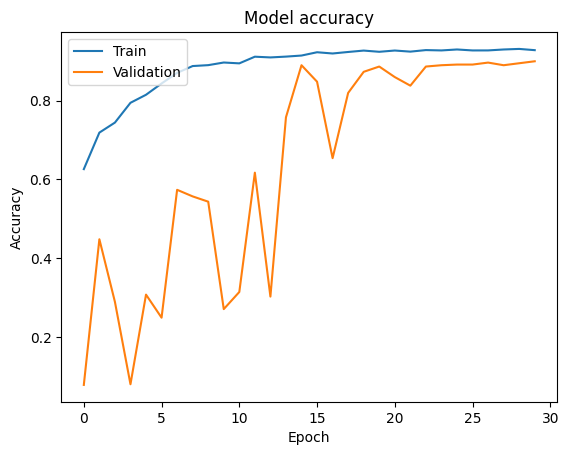

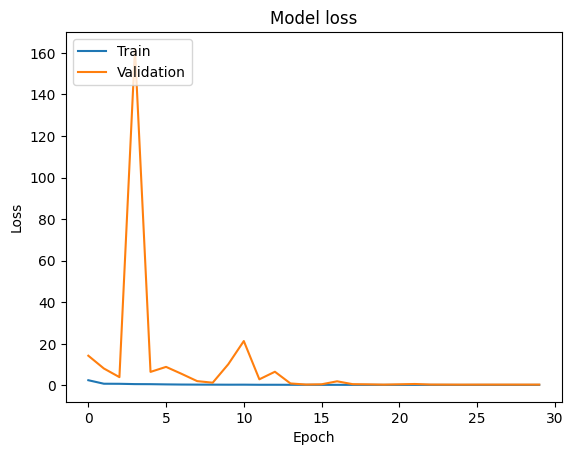

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate classification report and confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

print("Confusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()